<a href="https://colab.research.google.com/github/Gajalakshmi993/Harvard_Project/blob/main/Nutrition_paradox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import requests
import pandas as pd
obesity_a_url="https://ghoapi.azureedge.net/api/NCD_BMI_30C"
response = requests.get(obesity_a_url)
obesity_Adults = response.json()

In [73]:
obesity_b_url="https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C"
response1 = requests.get(obesity_b_url)
obesity_child = response1.json()


In [74]:
malnutrition_a_url = "https://ghoapi.azureedge.net/api/NCD_BMI_18C"
response3 = requests.get(malnutrition_a_url)
malnutrition_adults = response3.json()

In [75]:
malnutrition_c_url="https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"
response4 = requests.get(malnutrition_c_url)
malnutrition_child = response4.json()

In [76]:
df_obes_A= pd.DataFrame(obesity_Adults["value"])
df_obes_C = pd.DataFrame(obesity_child["value"])
df_malnutri_A = pd.DataFrame(malnutrition_adults["value"])
df_malnutri_C = pd.DataFrame(malnutrition_child["value"])

In [77]:
df_obes_A["age_group"] = "adults"
df_obes_C["age_group"] = "Child"
df_malnutri_A["age_group"] = "adults"
df_malnutri_C["age_group"] = "Child"

In [78]:
df_obesity = pd.concat([df_obes_A, df_obes_C], ignore_index = True)

In [79]:
df_malnutrition = pd.concat([df_malnutri_A, df_malnutri_C], ignore_index = True)

In [80]:
df_obesity["TimeDim"] = pd.to_numeric(df_obesity["TimeDim"], errors="coerce")
df_malnutrition["TimeDim"] = pd.to_numeric(df_malnutrition["TimeDim"], errors="coerce")


In [81]:
df_obesity = df_obesity[
    (df_obesity["TimeDim"] >= 2012) &
    (df_obesity["TimeDim"] <= 2022)
]

df_malnutrition = df_malnutrition[
    (df_malnutrition["TimeDim"] >= 2012) &
    (df_malnutrition["TimeDim"] <= 2022)
]


In [82]:
cols_to_keep = [
    "ParentLocation",
    "Dim1",
    "TimeDim",
    "Low",
    "High",
    "NumericValue",
    "SpatialDim",
    "age_group"]

df_obesity = df_obesity.filter(items = cols_to_keep)


In [83]:
df_malnutrition = df_malnutrition.filter(items = cols_to_keep)

In [84]:
rename_map = {
    "TimeDim": "Year",
    "Dim1": "Gender",
    "NumericValue": "Mean_Estimate",
    "Low": "LowerBound",
    "High": "UpperBound",
    "ParentLocation": "Region",
    "SpatialDim": "Country"
}

df_obesity = df_obesity.rename(columns=rename_map)
df_malnutrition = df_malnutrition.rename(columns=rename_map)

In [86]:
df_obesity["Gender"].unique()


array(['SEX_BTSX', 'SEX_MLE', 'SEX_FMLE'], dtype=object)

In [88]:
df_obesity["Gender"] = df_obesity["Gender"].replace({"SEX_FMLE" : "Female",
                                                     "SEX_MLE": "Male",
                                                     "SEX_BTSX" : "Both"})
df_malnutrition["Gender"] = df_malnutrition["Gender"].replace({"SEX_FMLE" : "Female",
                                                     "SEX_MLE": "Male",
                                                     "SEX_BTSX" : "Both"})

In [89]:
!pip install pycountry

In [90]:
import pycountry


In [91]:
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'WB_UMI': 'Upper Middle Income',
    'AFR': 'Africa',
    'AMR': 'Americas Region',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region'
}
def convert_country(code):
    # Handle special WHO / WB cases first
    if code in special_cases:
        return special_cases[code]

    # Handle standard ISO Alpha-3 country codes
    try:
        country = pycountry.countries.get(alpha_3=code)
        return country.name if country else None
    except:
        return None
for df_ in [df_obesity, df_malnutrition]:
    df_["Country"] = df_["Country"].apply(convert_country)

In [92]:
for df in [df_obesity, df_malnutrition]:
    df["CI_Width"] = df["UpperBound"] - df["LowerBound"]

In [93]:
df_obesity["obesity_level"] = "Low"   # default
df_obesity.loc[df_obesity["Mean_Estimate"] >= 30, "obesity_level"] = "High"
df_obesity.loc[df_obesity["Mean_Estimate"].between(25, 29.9),
               "obesity_level"] = "Moderate"

In [94]:
df_malnutrition["Malnutrition_level"] = "Low"   # default
df_malnutrition.loc[df_malnutrition["Mean_Estimate"] >= 20, "Malnutrition_level"] = "High"
df_malnutrition.loc[df_malnutrition["Mean_Estimate"].between(10, 19.9),
               "Malnutrition_level"] = "Moderate"

In [95]:
df_obesity.shape

(27720, 10)

In [96]:
df_malnutrition.shape

(27720, 10)

In [97]:
df_malnutrition.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27720 entries, 0 to 83157
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Region              26268 non-null  object 
 1   Gender              27720 non-null  object 
 2   Year                27720 non-null  int64  
 3   LowerBound          27720 non-null  float64
 4   UpperBound          27720 non-null  float64
 5   Mean_Estimate       27720 non-null  float64
 6   Country             27720 non-null  object 
 7   age_group           27720 non-null  object 
 8   CI_Width            27720 non-null  float64
 9   Malnutrition_level  27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.3+ MB


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [99]:
print("Obesity shape:", df_obesity.shape)
print("Malnutrition shape:", df_malnutrition.shape)

Obesity shape: (27720, 10)
Malnutrition shape: (27720, 10)


In [100]:
df_obesity.head()

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,obesity_level
0,Africa,Both,2022,7.699381,12.761527,9.952872,Mali,adults,5.062146,Low
4,Europe,Male,2014,25.753903,31.737372,28.709593,Ireland,adults,5.983469,Moderate
19,Europe,Female,2022,23.676629,41.304097,32.159114,Lithuania,adults,17.627468,High
21,Americas,Both,2014,34.908265,46.248028,40.481207,Saint Kitts and Nevis,adults,11.339763,High
24,Europe,Male,2021,21.260272,29.394928,25.170892,Türkiye,adults,8.134656,Moderate


In [101]:
df_malnutrition.head()

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,Malnutrition_level
0,Europe,Both,2019,0.996544,3.135328,1.894979,Bosnia and Herzegovina,adults,2.138784,Low
2,Americas,Female,2016,1.638843,6.502739,3.614240,Grenada,adults,4.863896,Low
3,Americas,Male,2020,0.999816,3.441858,1.987798,"Bolivia, Plurinational State of",adults,2.442042,Low
7,Africa,Both,2016,6.136775,13.009241,9.218783,Mauritania,adults,6.872466,Low
8,Europe,Female,2018,4.084366,6.334357,5.132326,France,adults,2.249991,Low


In [102]:
df_obesity.isna().sum()

,0
Region,1452
Gender,0
Year,0
LowerBound,0
UpperBound,0
Mean_Estimate,0
Country,0
age_group,0
CI_Width,0
obesity_level,0


In [103]:
(df_obesity.isna().mean() * 100).round(2)

,0
Region,5.24
Gender,0.00
Year,0.00
LowerBound,0.00
UpperBound,0.00
Mean_Estimate,0.00
Country,0.00
age_group,0.00
CI_Width,0.00
obesity_level,0.00


In [104]:
df_obesity.describe()
df_malnutrition.describe()

,Year,LowerBound,UpperBound,Mean_Estimate,CI_Width
count,27720.000000,27720.000000,27720.000000,27720.000000,27720.000000
mean,2017.000000,3.397094,8.147889,5.354451,4.750795
std,3.162335,3.908061,6.443692,4.811220,4.257683
min,2012.000000,0.023703,0.354833,0.175309,0.166679
25%,2014.000000,1.053666,3.143307,2.039278,1.603222
50%,2017.000000,1.907971,6.095557,3.597794,3.351093
75%,2020.000000,4.186440,11.526301,7.335245,6.530869
max,2022.000000,31.365401,43.680286,35.894114,26.701744


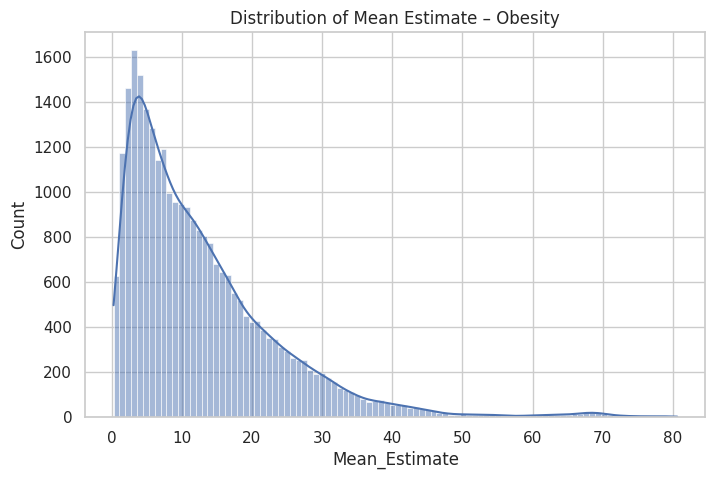

In [105]:
plt.figure(figsize=(8,5))
sns.histplot(df_obesity["Mean_Estimate"], kde=True)
plt.title("Distribution of Mean Estimate – Obesity")
plt.show()


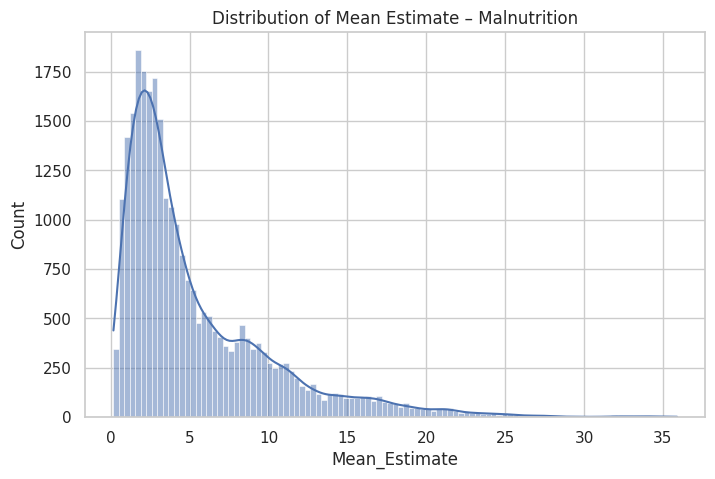

In [106]:
plt.figure(figsize=(8,5))
sns.histplot(df_malnutrition["Mean_Estimate"], kde=True)
plt.title("Distribution of Mean Estimate – Malnutrition")
plt.show()

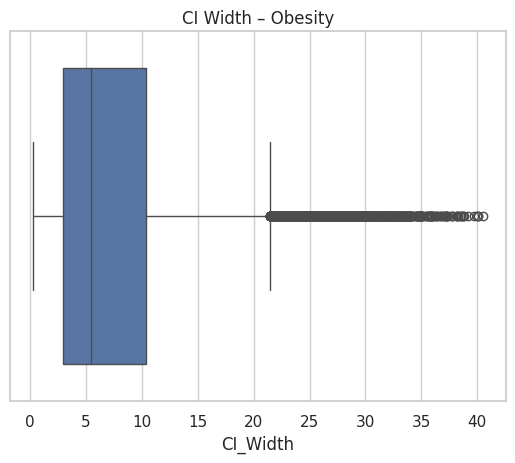

In [107]:
sns.boxplot(x=df_obesity["CI_Width"])
plt.title("CI Width – Obesity")
plt.show()

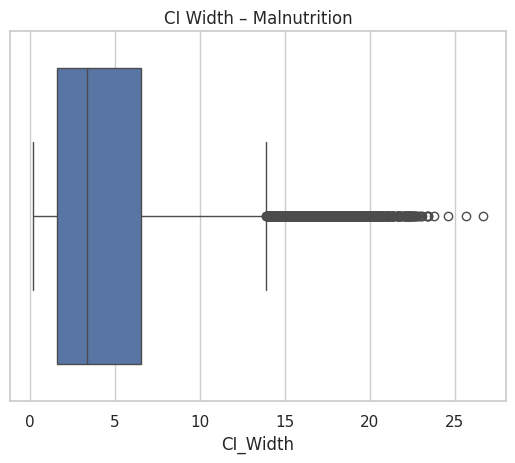

In [108]:
sns.boxplot(x=df_malnutrition["CI_Width"])
plt.title("CI Width – Malnutrition")
plt.show()

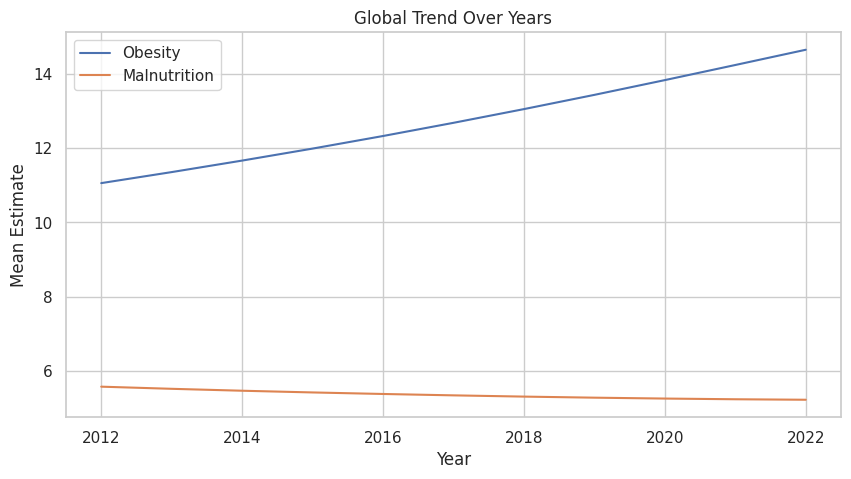

In [109]:
ob_year = df_obesity.groupby("Year")["Mean_Estimate"].mean()
mal_year = df_malnutrition.groupby("Year")["Mean_Estimate"].mean()

plt.figure(figsize=(10,5))
plt.plot(ob_year, label="Obesity")
plt.plot(mal_year, label="Malnutrition")
plt.legend()
plt.title("Global Trend Over Years")
plt.xlabel("Year")
plt.ylabel("Mean Estimate")
plt.show()

In [110]:
region_ob = df_obesity.groupby("Region")["Mean_Estimate"].mean().sort_values()
region_mal = df_malnutrition.groupby("Region")["Mean_Estimate"].mean().sort_values()

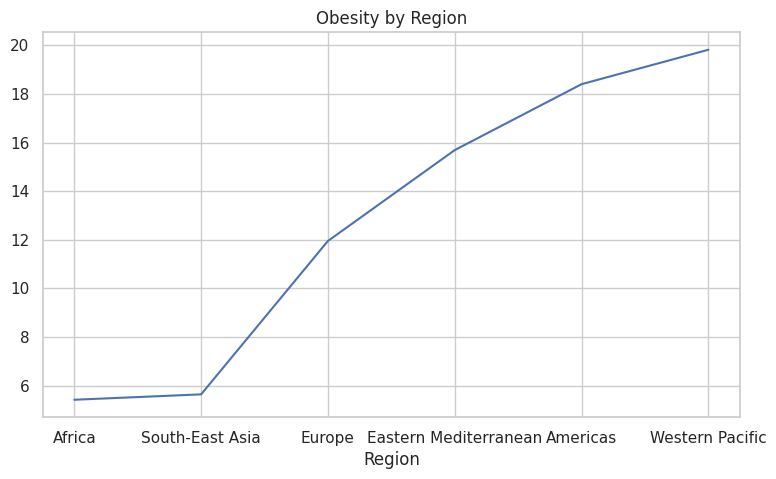

In [111]:
region_ob.plot(kind="line", figsize=(9,5), title="Obesity by Region")
plt.show()

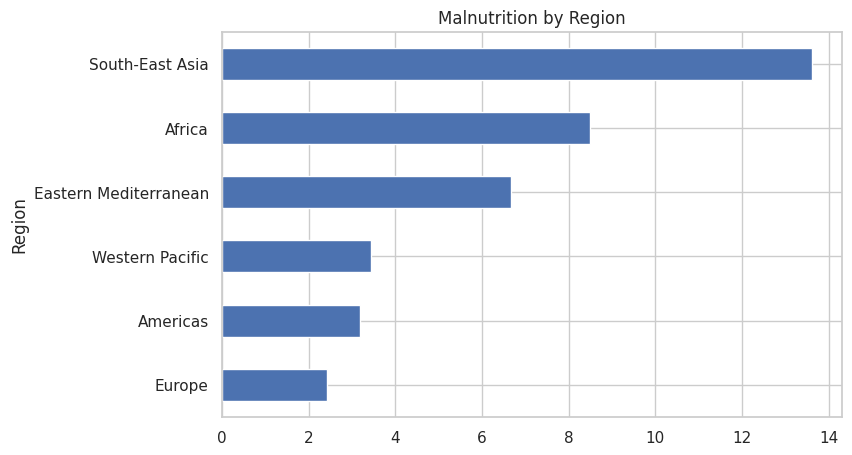

In [112]:
region_mal.plot(kind="barh", figsize=(8,5), title="Malnutrition by Region")
plt.show()

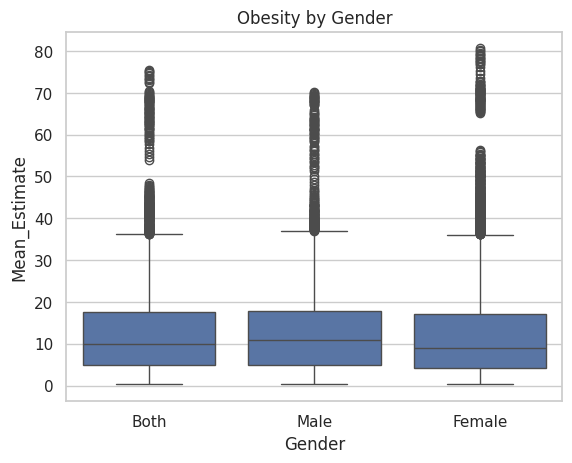

In [113]:
sns.boxplot(
    data=df_obesity,
    x="Gender",
    y="Mean_Estimate"
)
plt.title("Obesity by Gender")
plt.show()


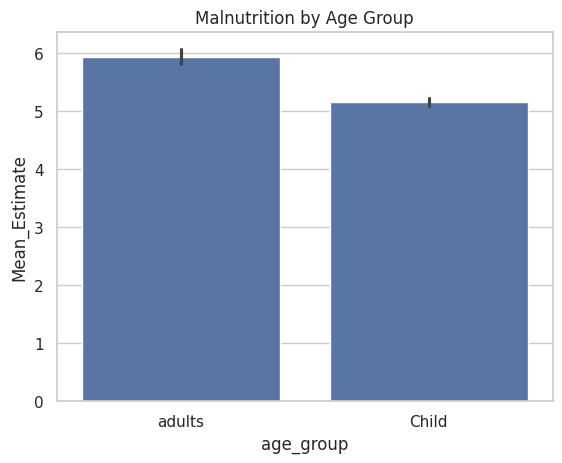

In [114]:
sns.barplot(
    data=df_malnutrition,
    x="age_group",
    y="Mean_Estimate"
)
plt.title("Malnutrition by Age Group")
plt.show()


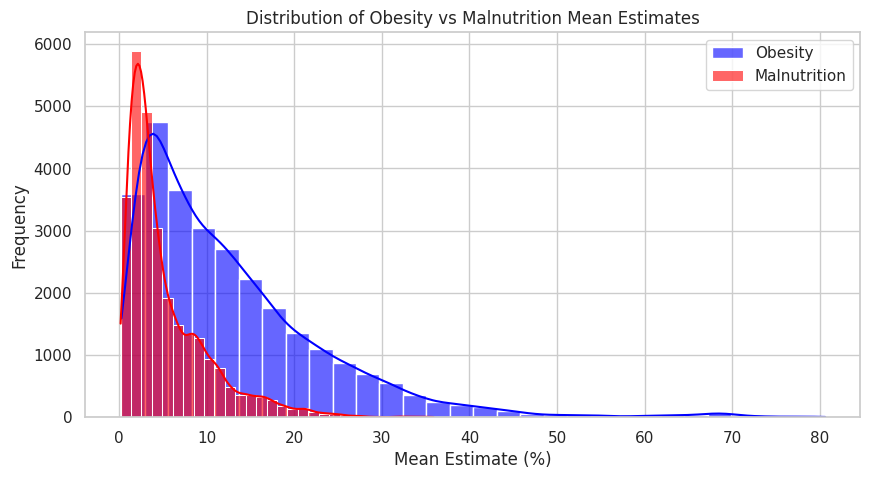

In [128]:
obesity_vals = df_obesity['Mean_Estimate'].dropna()
malnutrition_vals = df_malnutrition['Mean_Estimate'].dropna()
plt.figure(figsize=(10,5))

sns.histplot(obesity_vals, bins=30, kde=True, color='blue', label='Obesity', alpha=0.6)
sns.histplot(malnutrition_vals, bins=30, kde=True, color='red', label='Malnutrition', alpha=0.6)

plt.title("Distribution of Obesity vs Malnutrition Mean Estimates")
plt.xlabel("Mean Estimate (%)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [115]:
df_obesity["Region"] = df_obesity["Region"].fillna(df_obesity["Country"] if df_obesity["Region"].isna().any() else None)
df_malnutrition["Region"] = df_malnutrition["Region"].fillna(df_malnutrition["Country"] if df_malnutrition["Region"].isna().any() else None)

In [116]:
df_obesity["Region"].isna()
pd.set_option("display.max_rows", None)
df_obesity["Region"].unique()

array(['Africa', 'Europe', 'Americas', 'Eastern Mediterranean',
       'South-East Asia', 'Western Pacific', 'High Income', 'Low Income',
       'South-East Asia Region', 'Americas Region', 'Low & Middle Income',
       'Western Pacific Region', 'Global', 'Eastern Mediterranean Region',
       'Upper Middle Income'], dtype=object)

In [118]:
!pip install mysql-connector-python

In [119]:
import mysql.connector
conn = mysql.connector.connect(
    host="gateway01.ap-southeast-1.prod.aws.tidbcloud.com",
    user="2ZXpEbV7H6oqcRk.root",
    password="ukBi5oJt2r1h9Udi",
    port = 4000,
    database = "nutrition_db"
)

cursor = conn.cursor()

In [120]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS obesity (
    Region VARCHAR(100),
    Gender VARCHAR(50),
    Year INT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    Mean_Estimate FLOAT,
    Country TEXT,
    age_group TEXT,
    CI_Width FLOAT,
    obesity_level VARCHAR(50)
)""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS malnutrition (
    Region VARCHAR(100),
    Gender VARCHAR(50),
    Year INT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    Mean_Estimate FLOAT,
    Country TEXT,
    age_group TEXT,
    CI_Width FLOAT,
    malnutrition_level VARCHAR(50)
)""")

In [121]:
insert_obesity = """
INSERT INTO obesity (
    Region, Gender, Year, LowerBound, UpperBound,
    Mean_Estimate, Country, age_group, CI_Width, obesity_level
)
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
"""
obesity_data = list(
    df_obesity[[
        'Region', 'Gender', 'Year', 'LowerBound', 'UpperBound',
        'Mean_Estimate', 'Country', 'age_group', 'CI_Width', 'obesity_level'
    ]].itertuples(index=False, name=None)
)
cursor.executemany(insert_obesity, obesity_data)
conn.commit()


In [122]:
insert_malnutrition = """
INSERT INTO malnutrition (
    Region, Gender, Year, LowerBound, UpperBound,
    Mean_Estimate, Country, age_group, CI_Width, malnutrition_level
)
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
"""
malnutrition_data = list(
    df_malnutrition[[
        'Region', 'Gender', 'Year', 'LowerBound', 'UpperBound',
        'Mean_Estimate', 'Country', 'age_group', 'CI_Width', 'Malnutrition_level'
    ]].itertuples(index=False, name=None)
)
cursor.executemany(insert_malnutrition, malnutrition_data)
conn.commit()

In [123]:
queries = {
    1: {
        "desc": "Top 5 regions with the highest average obesity levels in the most recent year(2022)",
        "sql": """
              SELECT
              Region,
              AVG(Mean_Estimate) AS avg_obesity
              FROM obesity
              WHERE Year = 2022
              AND Region IS NOT NULL
              GROUP BY Region
              ORDER BY avg_obesity DESC
              LIMIT 5;
        """
    },
    2: {
        "desc": "Top 5 countries with highest obesity estimates",
        "sql": """
           SELECT
    Country,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity
WHERE Year = 2022
  AND Country IS NOT NULL
GROUP BY Country
ORDER BY avg_obesity DESC
LIMIT 5;
        """
    },
    3: {
        "desc": "Obesity trend in India over the years(Mean_estimate)",
        "sql": """
            SELECT
    year,
    gender,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity
WHERE country = 'India'
GROUP BY year, Gender
ORDER BY year, Gender;
        """
    },
    4: {
        "desc": "Average obesity by gender",
        "sql": """
            select Gender, avg(Mean_Estimate) as Avg_Obesity
                   from obesity
                   group by gender;
        """
    },
    5: {
        "desc": "Country count by obesity level category and age group",
        "sql": """
            select obesity_level, age_group, count(Country) as Number_of_Countries from obesity group by obesity_level, age_group;
        """
    },
    6: {
        "desc": "Top 5 countries least reliable countries(with highest CI_Width) and Top 5 most consistent countries (smallest average CI_Width)",
        "sql": """
            (
    SELECT
        'Least Reliable (High CI_Width)' AS category,
        Country,
        AVG(CI_Width) AS avg_ci_width
    FROM obesity
    WHERE Country IS NOT NULL
    GROUP BY Country
    ORDER BY avg_ci_width DESC
    LIMIT 5
)

UNION ALL

(
    SELECT
        'Most Consistent (Low CI_Width)' AS category,
        Country,
        AVG(CI_Width) AS avg_ci_width
    FROM obesity
    WHERE Country IS NOT NULL
    GROUP BY Country
    ORDER BY avg_ci_width ASC
    LIMIT 5
);
        """
    },
    7: {
        "desc": "Average obesity by age group",
        "sql": """
            select age_group, Avg(Mean_Estimate) as Avg_obesity from obesity group by age_group;;
        """
    },
    8: {
        "desc": "Top 10 Countries with consistent low obesity (low average + low CI)over the years",
        "sql": """
            SELECT
    Country,
    AVG(Mean_Estimate) AS avg_obesity,
    AVG(CI_Width) AS avg_CI_width
FROM obesity
GROUP BY Country
HAVING
    AVG(Mean_Estimate) IS NOT NULL
    AND AVG(CI_Width) IS NOT NULL
ORDER BY
    avg_obesity ASC,
    avg_ci_width ASC
LIMIT 10;
        """
    },
    9: {
        "desc": "Countries where female obesity exceeds male by large margin (same       year)",
        "sql": """
            SELECT
    f.Country,
    f.Year,
    f.Mean_Estimate AS female_obesity,
    m.Mean_Estimate AS male_obesity,
    (f.Mean_Estimate - m.Mean_Estimate) AS obesity_gap
FROM obesity f
JOIN obesity m
    ON f.Country = m.Country
    AND f.Year = m.Year
WHERE
    f.Gender = 'Female'
    AND m.Gender = 'Male'
    AND f.Mean_Estimate > m.Mean_Estimate
ORDER BY obesity_gap DESC
LIMIT 10;
        """
    },
   10: {
        "desc": "Global average obesity percentage per year",
        "sql": """
           SELECT
    Year,
    AVG(Mean_Estimate) AS global_avg_obesity
FROM obesity
WHERE Year IS NOT NULL
GROUP BY Year
ORDER BY Year;
        """
    },
    11: {
        "desc": "Avg. malnutrition by age group",
        "sql": """
           select  age_group , avg(Mean_Estimate) as Avg_Malnutrition
           from malnutrition
           where age_group is not null
           group by age_group;
        """
    },
      12: {
        "desc": "Top 5 countries with highest malnutrition(mean_estimate)",
        "sql": """
           SELECT
    Country,
    AVG(Mean_Estimate) AS avg_malnutrition
FROM malnutrition
WHERE Country IS NOT NULL
GROUP BY Country
ORDER BY avg_malnutrition DESC
LIMIT 5;

        """
    },
      13: {
        "desc": "Malnutrition trend in African region over the years",
        "sql": """
           SELECT
    Year,
    AVG(Mean_Estimate) AS avg_malnutrition
FROM malnutrition
WHERE Region = 'Africa'
  AND Year IS NOT NULL
GROUP BY Year
ORDER BY Year;
        """
    },
      14: {
        "desc": "Gender-based average malnutrition",
        "sql": """
            SELECT
    Gender,
    AVG(Mean_Estimate) AS avg_malnutrition
FROM malnutrition
WHERE Gender IS NOT NULL
GROUP BY Gender
ORDER BY avg_malnutrition DESC;
        """
    },
      15: {
        "desc": "Malnutrition level-wise (average CI_Width by age group)",
        "sql": """
          SELECT
    Age_Group,
    AVG(CI_Width) AS avg_ci_width
FROM malnutrition
WHERE Age_Group IS NOT NULL
GROUP BY Age_Group
ORDER BY avg_CI_width DESC;
        """
    },
      16: {
        "desc": "Yearly malnutrition change in specific countries(India, Nigeria, Brazil)",
        "sql": """
           SELECT
    Country,
    Year,
    AVG(Mean_Estimate) AS avg_malnutrition
FROM malnutrition
WHERE Country IN ('India', 'Nigeria', 'Brazil')
  AND Year IS NOT NULL
GROUP BY Country, Year
ORDER BY Country, Year;
        """
    },
      17: {
        "desc": "Regions with lowest malnutrition averages",
        "sql": """
           SELECT
    Region,
    AVG(Mean_Estimate) AS avg_malnutrition
FROM malnutrition
WHERE Region IS NOT NULL
GROUP BY Region
ORDER BY avg_malnutrition ASC;
        """
    },
      18: {
        "desc": " Countries with increasing malnutrition (💡 Hint: Use MIN() and MAX() on Mean_Estimate per country to compare early vs. recent malnutrition levels, and filter where the difference is positive using HAVING.)",
        "sql": """
           SELECT
    Country,
    MIN(Mean_Estimate) AS early_malnutrition,
    MAX(Mean_Estimate) AS recent_malnutrition,
    (MAX(Mean_Estimate) - MIN(Mean_Estimate)) AS malnutrition_change
FROM malnutrition
WHERE Country IS NOT NULL
GROUP BY Country
HAVING malnutrition_change > 0
ORDER BY malnutrition_change DESC;
        """
    },
      19: {
        "desc": "Min/Max malnutrition levels year-wise comparison",
        "sql": """
           SELECT
    Year,
    MIN(Mean_Estimate) AS min_malnutrition,
    MAX(Mean_Estimate) AS max_malnutrition
FROM malnutrition
WHERE Year IS NOT NULL
GROUP BY Year
ORDER BY Year;
        """
    },
      20: {
        "desc": "High CI_Width flags for monitoring(CI_width > 5)",
        "sql": """
           SELECT
    Country,
    Year,
    Age_Group,
    Gender,
    CI_Width,
    CASE
        WHEN CI_Width > 5 THEN 'High CI_Width – Monitor'
        ELSE 'Normal'
    END AS ci_flag
FROM malnutrition
WHERE CI_Width > 5
ORDER BY CI_Width DESC;
        """
    },
      21: {
        "desc": "Obesity vs malnutrition comparison by country(any 5 countries)",
        "sql": """
          SELECT
    o.Country,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.Mean_Estimate) AS avg_malnutrition
FROM obesity o
JOIN malnutrition m
    ON o.Country = m.Country
    AND o.Year = m.Year
WHERE o.Country IN ('India', 'Nigeria', 'Brazil', 'USA', 'China')
GROUP BY o.Country
ORDER BY avg_obesity DESC;
        """
    },
      22: {
        "desc": "Gender-based disparity in both obesity and malnutrition",
        "sql": """
           SELECT
    o.Country,
    o.Gender,
    ROUND(AVG(o.Mean_Estimate), 2) AS avg_obesity,
    ROUND(AVG(m.Mean_Estimate), 2) AS avg_malnutrition
FROM obesity o
JOIN malnutrition m
    ON o.Country = m.Country
    AND o.Year = m.Year
    AND o.Gender = m.Gender
WHERE o.Country IN ('India', 'Nigeria', 'Brazil', 'USA', 'China')
  AND o.Gender IN ('Male', 'Female')
GROUP BY o.Country, o.Gender
ORDER BY o.Country, o.Gender;;
        """
    },
      23: {
        "desc": "Region-wise avg estimates side-by-side(Africa and America)",
        "sql": """
           SELECT
    o.Region,
    ROUND(AVG(o.Mean_Estimate), 2) AS avg_obesity,
    ROUND(AVG(m.Mean_Estimate), 2) AS avg_malnutrition
FROM obesity o
JOIN malnutrition m
    ON o.Country = m.Country
    AND o.Year = m.Year
    AND o.Region = m.Region
WHERE o.Region IN ('Africa', 'Americas')
GROUP BY o.Region
ORDER BY o.Region;
        """
    },
      24: {
        "desc": "Countries with obesity up & malnutrition down",
        "sql": """
           SELECT
    o.Country,
    ROUND(MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate), 2) AS obesity_change,
    ROUND(MAX(m.Mean_Estimate) - MIN(m.Mean_Estimate), 2) AS malnutrition_change
FROM obesity o
JOIN malnutrition m
    ON o.Country = m.Country
    AND o.Year = m.Year
WHERE o.Country IS NOT NULL
GROUP BY o.Country
HAVING obesity_change > 0
   AND malnutrition_change < 0;
        """
    },
      25: {
        "desc": "Age-wise trend analysis",
        "sql": """
          SELECT
    o.age_group,
    o.Year,
    ROUND(AVG(o.Mean_Estimate), 2) AS avg_obesity,
    ROUND(AVG(m.Mean_Estimate), 2) AS avg_malnutrition
FROM obesity o
JOIN malnutrition m
    ON o.Country = m.Country
    AND o.Year = m.Year
    AND o.age_group = m.age_group
GROUP BY o.age_group, o.Year
ORDER BY o.age_group, o.Year;
        """
    }
}


In [124]:
def run_query(query_no):

    if query_no not in queries:
        print("❌ Invalid query number")
        return None

    cursor.execute(queries[query_no]["sql"])
    rows = cursor.fetchall()

    columns = [col[0] for col in cursor.description]
    df = pd.DataFrame(rows, columns=columns)

    return df

In [127]:
while True:
    print("\n📌 Available SQL Queries:\n")

    for k, v in queries.items():
        print(f"{k}. {v['desc']}")

    choice = input("\nEnter query number: ")

    if not choice.isdigit():
        print("❌ Please enter a valid number")
        continue

    df = run_query(int(choice))

    if df is not None:
        print("\n📊 Query Result:\n")
        print(df)

    again = input("\nDo you want to run another query? (yes/no): ").lower()
    if again == "no":
        print("✅ Exiting program")
        break



📌 Available SQL Queries:

1. Top 5 regions with the highest average obesity levels in the most recent year(2022)
2. Top 5 countries with highest obesity estimates
3. Obesity trend in India over the years(Mean_estimate)
4. Average obesity by gender
5. Country count by obesity level category and age group
6. Top 5 countries least reliable countries(with highest CI_Width) and Top 5 most consistent countries (smallest average CI_Width)
7. Average obesity by age group
8. Top 10 Countries with consistent low obesity (low average + low CI)over the years
9. Countries where female obesity exceeds male by large margin (same       year)
10. Global average obesity percentage per year
11. Avg. malnutrition by age group
12. Top 5 countries with highest malnutrition(mean_estimate)
13. Malnutrition trend in African region over the years
14. Gender-based average malnutrition
15. Malnutrition level-wise (average CI_Width by age group)
16. Yearly malnutrition change in specific countries(India, Nigeria,